# 80's A-Z

Well it's December and for the thrid year in a row,
it's time for the [WXPN](http://www.xpn.org) A-Z countdown.
This time we are returning to the 1980s with 
the [XPN 80's A-Z](http://www.xpn.org/music-artist/xpn-a-z).
And once again taking a crack at doing statistical analysis along the way.


In [1]:
%matplotlib inline
from IPython.display import display, HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.input').hide();
    } else {
        $('div.input').show();
    }
        code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')

## Status

 * It's been a week and a half and we just moved into W.
   Time for new features is probably limited.
   Mostly trying to be timely now.
 * Analysis is pretty much have things on a par
   with [last year's work](70sA2Z.ipynb).
   May follow up on a few suggestions retroactivly.
 * Managed to re-add data augmentation with [MusicBrainz](https://musicbrainz.org/),
   so have stats by year, though they lag a bit as a small but significant
   number of tracks fail to match and require manual intervention to resolve.
 * Added comparisions with pervious playlists, so we see where this is heading.


## Loading the data

Most people are not interested in how I pull and clean the data.
If you are, feel free to look at [my Data Loading notebook](DataLoading.ipynb).
If you just want a copy of the raw data,
feel free to grab a copy of [80sA2Z.csv](./data/80sA2Z.csv).

In [2]:
import pandas as pd
from datetime import date, datetime, time
from os import path
data_dir = './data'
playlist_file = path.join(data_dir, '80sA2Z.csv')
playlist = pd.read_csv(playlist_file)
playlist['Air Time'] = pd.to_datetime(playlist['Air Time'], errors='coerce')
HTML('<p>So far, as of %s, we have seen %d tracks with %d unique titles, from %d artists.</p>' %\
    (playlist['Air Time'].max().strftime('%b %d %I:%M%p'),
     len(playlist),
     playlist.describe(include='all')['Title']['unique'], 
     playlist.describe(include='all')['Artist']['unique']
     ))

Note, that right now there is a gap in the playlist data from 9pm to midnight on 12-8.
WXPN assures us that the elves will fix that,
but having fixed the playlist feed, the elves deserve sleep.

## Data Analysis

### Songs by Letter

This was the first thing I looked at origionally,
and it serves as a good "how are we doing" metric during the count down.
I promise, it will look better once there are a few more letters.

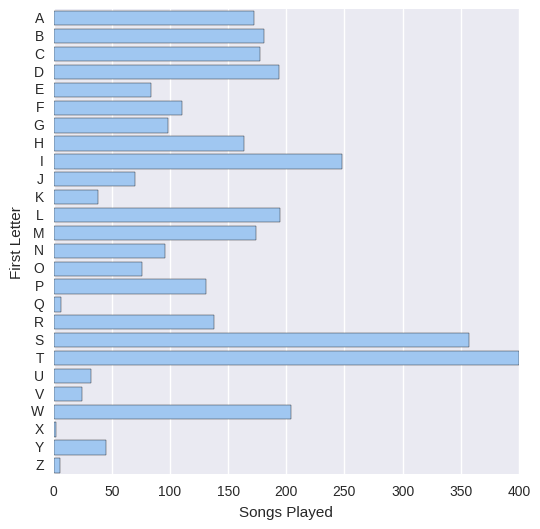

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes('pastel')
sns.countplot(y='Letter', data=playlist, color='b')
ax.set(xlabel="Songs Played", ylabel="First Letter")

In [4]:
c = playlist['Letter'].value_counts()
letters = pd.DataFrame(zip(c.keys().tolist(), c.tolist()), columns=('Letter', 'Count'))
letters_csv = path.join(data_dir, '80s_letters.csv')
letters.to_csv(letters_csv, index=False)
HTML('<p>The same data is availiable as <a href="%s">%s</a>.<p>' % (letters_csv, path.basename(letters_csv)))


### Songs by Year

Given the decade orientation this time,
it makes sense to break the songs down by year.

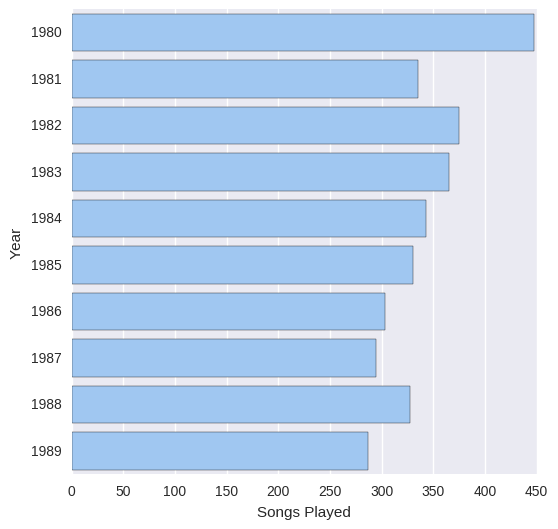

In [5]:
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes('pastel')
sns.countplot(y='Year', data=playlist[playlist['Year'] > 0], color='b')
ax.set(xlabel="Songs Played", ylabel="Year")

In [6]:
c = playlist['Year'].value_counts()
years = pd.DataFrame(zip(c.keys().tolist(), c.tolist()), columns=('Year', 'Count'))
years = years[years['Year'] > 0]
years_csv = path.join(data_dir, '80s_years.csv')
years.to_csv(years_csv, index=False)
HTML('<p>The same data is availiable as <a href="%s">%s</a>.<p>' % (years_csv, path.basename(years_csv)))

### Most Popular Artists

The origional playlist was dominated by the Beatles.
The 70s list was a bit more even,
and it was kind of fun to watch the lead change over time.
We'll see how the 90's goes,
but so far ...

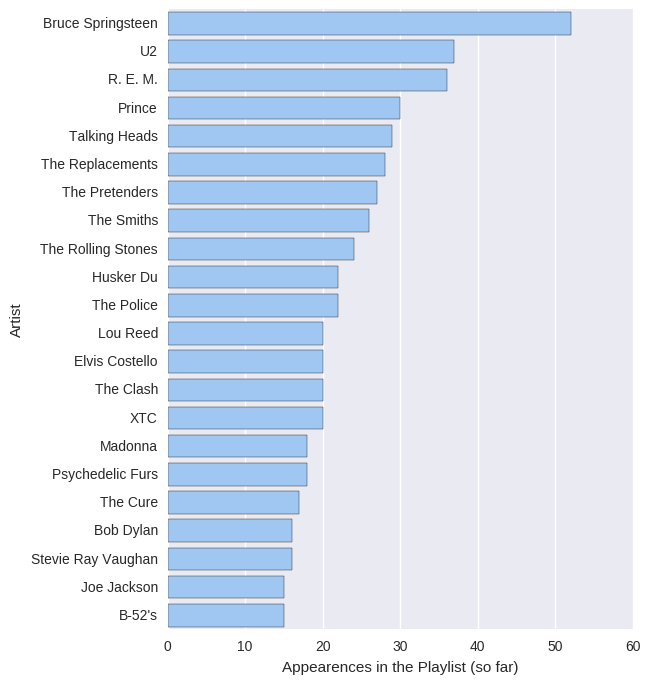

In [7]:
c = playlist['Artist'].value_counts()
artists = pd.DataFrame(zip(c.keys().tolist(), c.tolist()),
                       columns=('Artist', 'Count'))
f, ax = plt.subplots(figsize=(6, 8))
sns.set_color_codes('pastel')
sns.barplot(y='Artist', x='Count', data=artists[artists['Count'] > 14], color='b')
ax.set(xlabel="Appearences in the Playlist (so far)")

In [8]:
artists_csv = path.join(data_dir, '80s_artists.csv')
artists.to_csv(artists_csv, index=False)
HTML('<p>The same data is availiable as <a href="%s">%s</a>.<p>' % (artists_csv, path.basename(artists_csv)))


### Artists Who Have Played For The Most Time

This isn't overly accurate, as it is based on the sucessive start times
in the playlist, and those only have one minute granularity.
Plus the hosts do pause to talk every few songs,
and that isn't factored out.
But it's the best we have.
Besides someone asked about this.
Playing more songs helps with total duration,
but so does long songs.

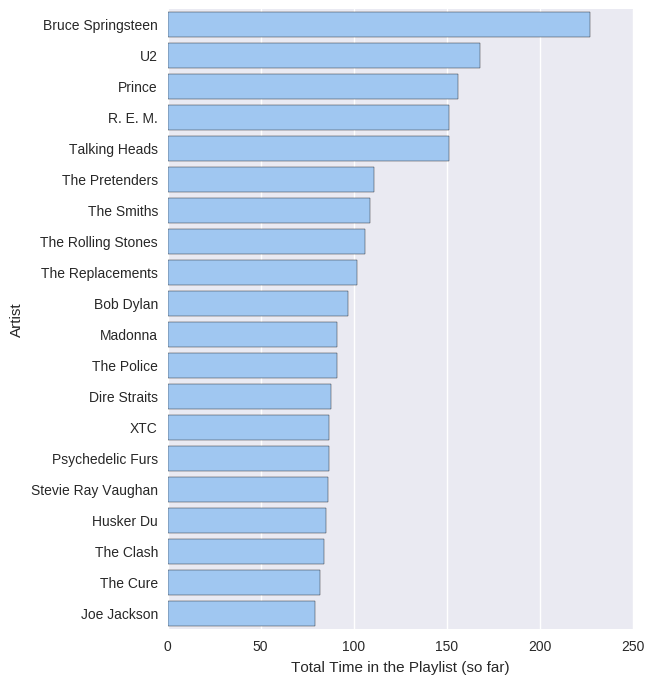

In [9]:
artist_durations = playlist.groupby('Artist')['Duration'].sum().to_frame()
artist_durations = artist_durations.reset_index()
artist_durations = artist_durations.sort_values(by='Duration', ascending=False)

f, ax = plt.subplots(figsize=(6, 8))
sns.set_color_codes('pastel')
sns.barplot(y='Artist', x='Duration', data=artist_durations.head(20), color='b')
ax.set(xlabel="Total Time in the Playlist (so far)")

In [10]:
artist_durations_csv = path.join(data_dir, '80s_artist_durations.csv')
artist_durations.to_csv(artist_durations_csv, index=False)
HTML('<p>The same data is availiable as <a href="%s">%s</a>.<p>' % (artist_durations_csv, path.basename(artist_durations_csv)))


### Coverage

Has any artist played all the letteres so far?
If not, who came close?
How about all the years?
That takes fewer songs in the countdown,
but places an onus on career longevity.

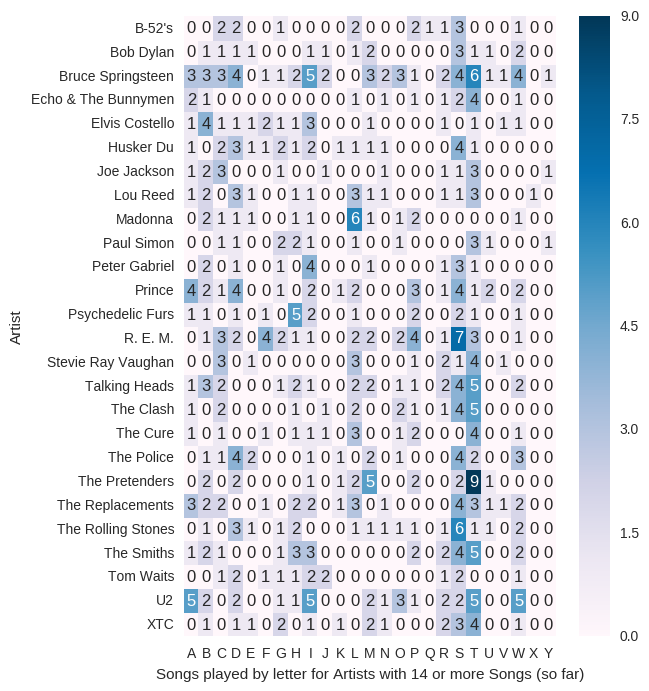

In [11]:
c = playlist[playlist.groupby('Artist')['Artist'].transform('size') >= 14]
c = c.groupby(['Artist', 'Letter']).count()
c.reset_index(level=[0,1], inplace=True)
c = c.pivot('Artist', 'Letter', 'Title').fillna(0)
f, ax = plt.subplots(figsize=(6, 8))
sns.set_color_codes('pastel')
ax = sns.heatmap(c, annot=True, cmap='PuBu')
ax.set(xlabel="Songs played by letter for Artists with 14 or more Songs (so far)")

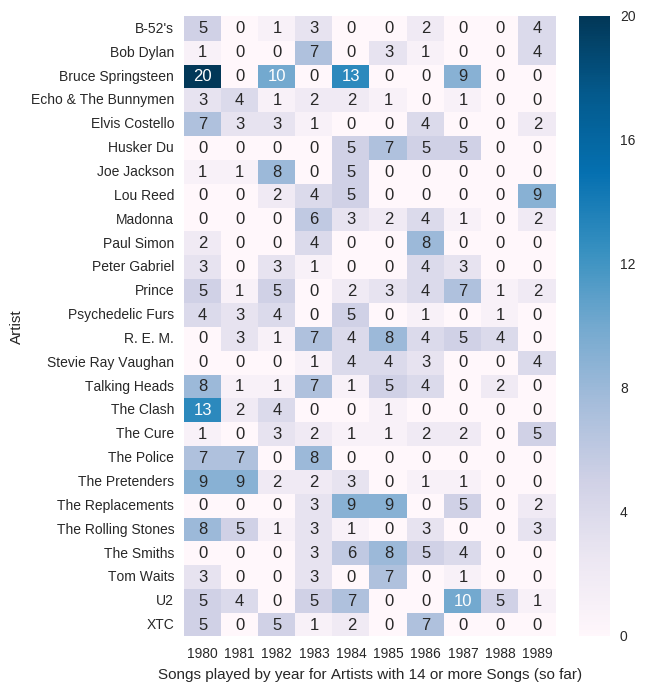

In [12]:
c = playlist[playlist.groupby('Artist')['Artist'].transform('size') >= 14]
c = c[c['Year'] > 0]
c = c.groupby(['Artist', 'Year']).count()
c.reset_index(level=[0,1], inplace=True)
c = c.pivot('Artist', 'Year', 'Title').fillna(0)
f, ax = plt.subplots(figsize=(6, 8))
sns.set_color_codes('pastel')
ax = sns.heatmap(c, annot=True, cmap='PuBu')
ax.set(xlabel="Songs played by year for Artists with 14 or more Songs (so far)")

### First words

Part of what started this last year was looking at first words.
I didn't think that would be interesting,
but when "I" took over the huge run of the letter I,
I figured it was worth watching.

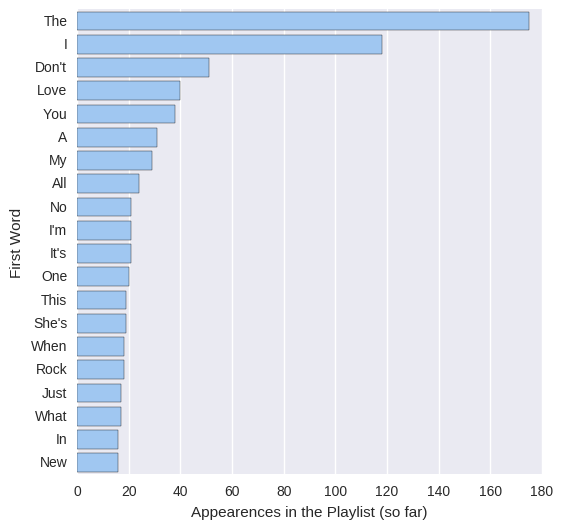

In [13]:
c = playlist['First Word'].value_counts()
words = pd.DataFrame(zip(c.keys().tolist(), c.tolist()),
                       columns=('First Word', 'Count'))

f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes('pastel')
sns.barplot(y='First Word', x='Count', data=words.head(20), color='b')
ax.set(xlabel="Appearences in the Playlist (so far)")

In [14]:
first_words_csv = path.join(data_dir, '80s_first_words.csv')
words.head(50).to_csv(first_words_csv, columns=['First Word', 'Count'], index=False)
HTML('<p>The same data is availiable as <a href="%s">%s</a>.<p>' % (first_words_csv, path.basename(first_words_csv)))


### Longest Songs

We can look at which songs took the longest.
Warning "Other Arms" wasn't really that long.
The playlist I scrape is missing a song or two.
If that isn't updated, I'll try to manually fix it.
"Divided Sky", well that's by Phish, so yea, it's legit.

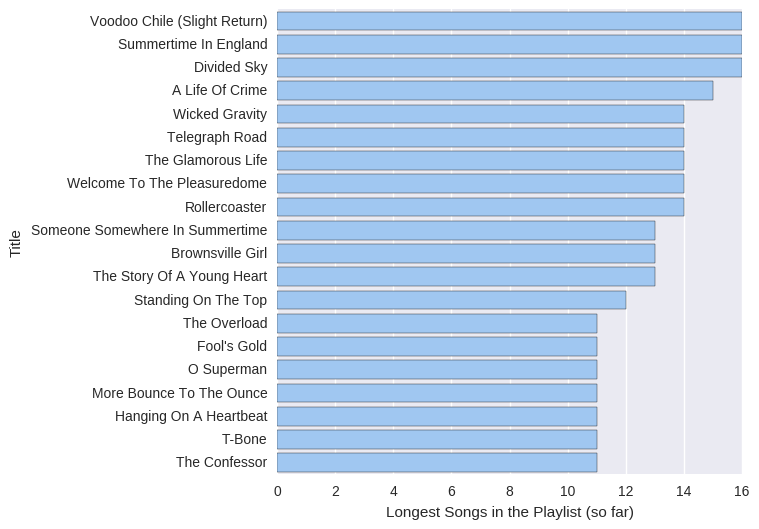

In [15]:
long_songs = playlist.sort_values(by='Duration', ascending=False)
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes('pastel')
sns.barplot(y='Title', x='Duration', data=long_songs.head(20), color='b')
ax.set(xlabel="Longest Songs in the Playlist (so far)")

In [16]:
long_songs_csv = path.join(data_dir, '80s_long_songs.csv')
long_songs.head(20).to_csv(long_songs_csv, columns=['Artist', 'Title', 'Duration'], index=False)
HTML('<p>The same data is availiable as <a href="%s">%s</a>.<p>' % (long_songs_csv, path.basename(long_songs_csv)))

### Comparision with other XPN Playlists

#### 885 Best and 88 Worst

Before the dawn of A-Z,
XPN did year end countdowns based on listener vote.
In 2014 the main list was the 885 Best Songs of All Time.
It had a parallel mini-list the 88 Worst Songs of All time.

So for eveyone in twitterdom, who is compaining 
"why is *song* or *anything by artist* in this countdown?"
lets's see what the overlap is.

In [17]:
best885_file = path.join(data_dir, '885best.csv')
best885 = pd.read_csv(best885_file)

worst88_file = path.join(data_dir, '88worst.csv')
worst88 = pd.read_csv(worst88_file)

besties = pd.merge(playlist, best885, how='inner', on=['Title', 'Artist'])
besties.to_csv(path.join(data_dir, '80s_and_885Best.csv'), index=False)
horrors = pd.merge(playlist, worst88, how='inner', on=['Title', 'Artist'])
horrors.to_csv(path.join(data_dir, '80s_and_88Worst.csv'), index=False)

s= "<p>Of the %d tracks in the 80s A-Z so far, " + \
    "%d or %0.2f%% where in 2014's 885 best playlist. " + \
    "Those are availiable as <a href='data/80s_and_885Best.csv'>80s_and_885Best.csv</a>. " + \
    "Sadly %d were in 2014's 88 worst playlist. " + \
    "Those are available as <a href='data/80s_and_88Worst.csv'>80s_and_88Worst.csv</a>.</p>"
HTML(s %(len(playlist), len(besties), float(len(besties) * 100) / float(len(playlist)),
         len(horrors)))

So what were the songs that were part of 88Worst?

In [18]:
HTML(horrors.to_html(index=False, columns=['Title', 'Artist']))

Title,Artist
Come On Eileen,Dexy's Midnight Runners
Don't Stop Believin',Journey
Livin' On A Prayer,Bon Jovi
Mickey,Toni Basil
Mr. Roboto,Styx
Never Gonna Give You Up,Rick Astley
Party All The Time,Eddie Murphy
Sussudio,Phil Collins
Uptown Girl,Billy Joel
We Built This City,Starship


In truth it's worse than that,
two tracks that were on the 88Worst, but spelled differently,
so as not to match:

 - Born In the USA by Bruce Sprintsteen
 - Ebony and Ivory by Paul McCartney and Stevie Wonder

But keep in mind, a good number of the 88Worst were really
"someone else's favorite song you got tired of hearing."

#### Previous A-Z Countdowns

Last year there was a 70's A-Z Countdown,
and in 2016 there was the origional generic A-Z Countdown.
We can compare the current playlist to them.

In [19]:
originals_file = path.join(data_dir, 'A2Z.csv')
originals = pd.read_csv(originals_file)

seventies_file = path.join(data_dir, '70sA2Z.csv')
seventies = pd.read_csv(seventies_file)

reruns = pd.merge(playlist, originals, how = 'inner', on = ['Title', 'Artist'])
reruns_file = path.join(data_dir, '80s_reruns.csv')
reruns.to_csv(reruns_file, index=False, encoding='utf-8')

s = """
    <p>Of the %d tracks played so far, %d tracks or %0.2f%%
    were played as part of the origional play list.
    The list is in <a href='%s'>%s</a></p>.
"""

HTML(s % (len(playlist), len(reruns), float(len(reruns) * 100)/float(len(playlist)),
         reruns_file, path.basename(reruns_file)))

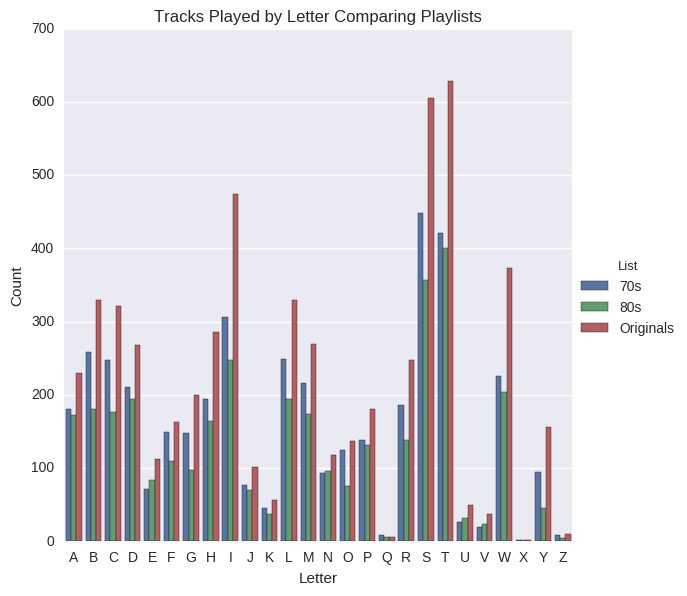

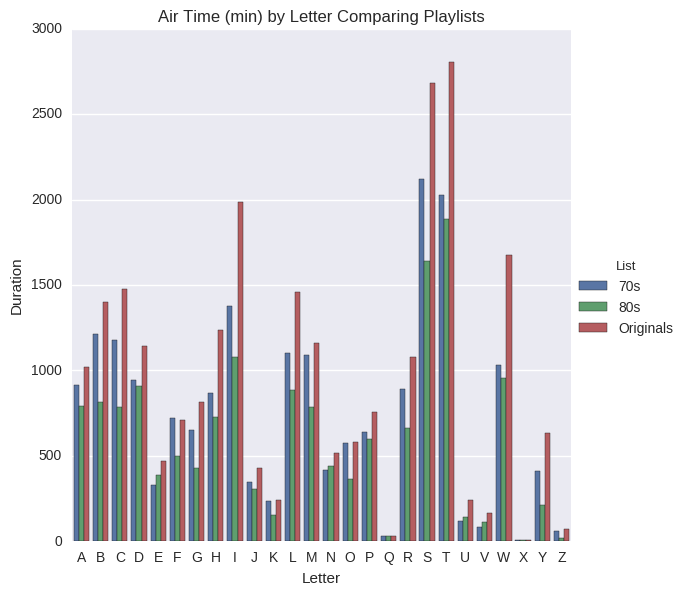

In [20]:
playlist['List'] = '80s'
playlist['Count'] = 1
seventies['List'] = '70s'
seventies['Count'] = 1
originals['List'] = 'Originals'
originals['Count'] = 1

combined = pd.concat([originals, seventies, playlist])
summary = combined.groupby(['List', 'Letter'])['Count', 'Duration'].sum()
summary = summary.reset_index()
sns.set_color_codes('pastel')
sns.factorplot(x='Letter', y='Count', hue='List', data=summary, kind='bar', size=6)
sns.plt.title('Tracks Played by Letter Comparing Playlists')
sns.factorplot(x='Letter', y='Duration', hue='List', data=summary, kind='bar', size=6)
sns.plt.title('Air Time (min) by Letter Comparing Playlists')

### Duplicate Titles

Duplicate titles are not necessarily covers.
Many are.  Other times it is case of "same title, different song."
There have been a lot of 2 songs same title,
but only a few with more than two songs.

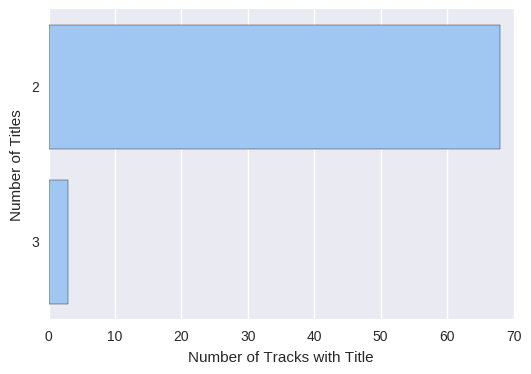

In [21]:
c = playlist['Title'].value_counts()
title_counts = pd.DataFrame(zip(c.keys().tolist(), c.tolist()),
                           columns=('Title', 'Count'))
f, ax = plt.subplots(figsize=(6, 4))
sns.set_color_codes('pastel')
sns.countplot(y='Count', data=title_counts[title_counts['Count'] > 1], color='b')
ax.set(xlabel="Number of Tracks with Title", ylabel="Number of Titles")

In [22]:


HTML(title_counts[title_counts['Count'] > 2].sort_values(by='Title').to_html(index=False))

Title,Count
Desire,3
Heartbeat,3
Magic,3


## Availability

The code for this project is in [my git hub repo](https://github.com/asudell/a2z).
The notebook its self is [published on nbviewer](http://nbviewer.jupyter.org/github/asudell/a2z/blob/master/80sAtoZ.ipynb)

## License

This project is licensed under a
[Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).
You are free to use for commercial or non-commercial purposes,
so long as you attribute the source and also allow sharing.